## Implementing DeepDream in Keras

We firstly load the InceptionV3 model which tends to produce some of the best visuals. Feel free to try VGG16, VGG19, Xception and ResNet50.

Code obtained and edited from F. Chollet (Created of Keras)
- 
https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.2-deep-dream.ipynb

In [1]:
from keras.applications import inception_v3
from keras import backend as K

# This setting disables all training specific operations
K.set_learning_phase(0)

# Load InceptionV3
model = inception_v3.InceptionV3(weights = 'imagenet', include_top = False)


Using TensorFlow backend.


#### We create a dictionary of coefficients quantifying, how much the layer’s activation contributes to the loss you’ll seek to maximize

In [10]:
layer_contributions = {
    'mixed2': 0.7,
    'mixed3': 2.2,
    'mixed4': 1.2,
    'mixed5': .2,
}

#### Define our tensor that contains the maximized Loss (the weighted sum of the L2 norm of the activations of the layer defined above)

In [11]:
# Map layer names to layer instances
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# loss defined by adding layer contributions
loss = K.variable(0.)

for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    
    # activation gets the layer output
    activation = layer_dict[layer_name].output
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))

    # we add the l2 norm
    loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

### Creating the Gradient-Ascent Process

In [12]:
# this is the image or 'dream' :) that is stored in this tensor 
dream = model.input

# Obtains the gradients wrt to the loss
grads = K.gradients(loss, dream)[0]

# Normalizes the gradient 
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# Creates a Keras function to get the value of the loss & gradients wrt to the input
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    """returns the loss and gradient values"""
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    """Implements gradient access for a specified number of iterations"""
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

## Implementing the Deep Dream Algorithm

In [13]:
import numpy as np
import scipy
from keras.preprocessing import image
import imageio

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2], 1)
    return scipy.ndimage.zoom(img, factors, order=1)

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    imageio.imwrite(fname, pil_img)

def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

step = 0.01 #Step size for gradient ascent
num_octave = 3 #number of octaves to be run
octave_scale = 1.4 #this is the scale for each ensuing octive will be 1.4 times large than the previous
iterations = 20 #number of gradient ascent operations we execute 
max_loss = 10.0 #our early stoping metric, if loss is > max_loss we break the gradient ascent loop

base_image_path = 'E:\\Computer vision\\learnopencv\\pratice\\ntr.JPG'

# Load our image 
img = preprocess_image(base_image_path)

# Initialize a list of tuples for our different images sizes/scales 
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# Reverse list of shapes, so that they are in increasing order
successive_shapes = successive_shapes[::-1]

# Resize the Numpy array of the image to our smallest scale
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)

    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='E:\\Computer vision\\learnopencv\\pratice\\' + str(shape) + '.png')
    
save_img(img, fname='E:\\Computer vision\\learnopencv\\pratice\\final_dream2.png')
print("DeepDreaming Complete")

Processing image shape (390, 281)
...Loss value at 0 : 1.5826988
...Loss value at 1 : 2.007855
...Loss value at 2 : 2.5125766
...Loss value at 3 : 3.0418499
...Loss value at 4 : 3.5419345
...Loss value at 5 : 4.0177674
...Loss value at 6 : 4.4817357
...Loss value at 7 : 4.8783274
...Loss value at 8 : 5.291538
...Loss value at 9 : 5.655498
...Loss value at 10 : 6.052078
...Loss value at 11 : 6.406764
...Loss value at 12 : 6.7975984
...Loss value at 13 : 7.112199
...Loss value at 14 : 7.458181
...Loss value at 15 : 7.744594
...Loss value at 16 : 8.054851
...Loss value at 17 : 8.359404
...Loss value at 18 : 8.641277
...Loss value at 19 : 8.9311905
Processing image shape (546, 393)
...Loss value at 0 : 2.5387335
...Loss value at 1 : 3.562004
...Loss value at 2 : 4.365391
...Loss value at 3 : 5.0173907
...Loss value at 4 : 5.6388636
...Loss value at 5 : 6.1465297
...Loss value at 6 : 6.647279
...Loss value at 7 : 7.106418
...Loss value at 8 : 7.5217533
...Loss value at 9 : 7.9021473
...Loss

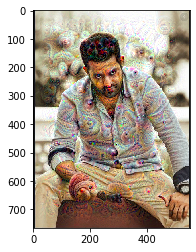

In [15]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

image_path = 'E:\\Computer vision\\learnopencv\\pratice\\final_dream2.png'

# Show our Final Dream Image 
img1 = image.load_img(image_path)
plt.imshow(img1);
